# Grad-CAM class activation visualization in Keras

Adapted from Deep Learning with Python (2017)

## Setup

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2

## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` and `classifier_layer_names`, use `model.summary()` to see the names of all layers in the model.

In [0]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'block14_sepconv2_act'
classifier_layer_names = [
  'avg_pool',
  'predictions',
]

# The local path to our target image
img_path = keras.utils.get_file('african_elephant.jpg', ' https://i.imgur.com/Bvro0YD.png')

4218880/4217496 [==============================] - 1s 0us/step


In [0]:
display(Image(img_path))

## The Grad-CAM algorithm

In [0]:
def get_img_array(img_path, size):
  # `img` is a PIL image of size 224x224
  img = keras.preprocessing.image.load_img(img_path, target_size=size)
  # `array` is a float32 Numpy array of shape (224, 224, 3)
  array = keras.preprocessing.image.img_to_array(img)
  # We add a dimension to transform our array into a "batch"
  # of size (1, 224, 224, 3)
  array = np.expand_dims(array, axis=0)
  return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

  # Second, we create a model that maps the activations of the last conv
  # layer to the final class predictions
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last conv layer
  grads = tape.gradient(top_class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

## Let's test-drive it

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.8871445)]


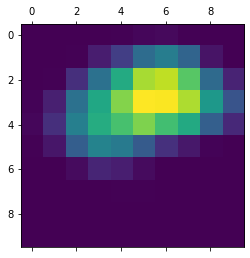

In [0]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights='imagenet')

# Print what the top predicted class is
preds = model.predict(img_array)
print('Predicted:', decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Create a superimposed visualization

In [0]:
# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
save_path = 'elephant_cam.jpg'
cv2.imwrite(save_path, superimposed_img)

True

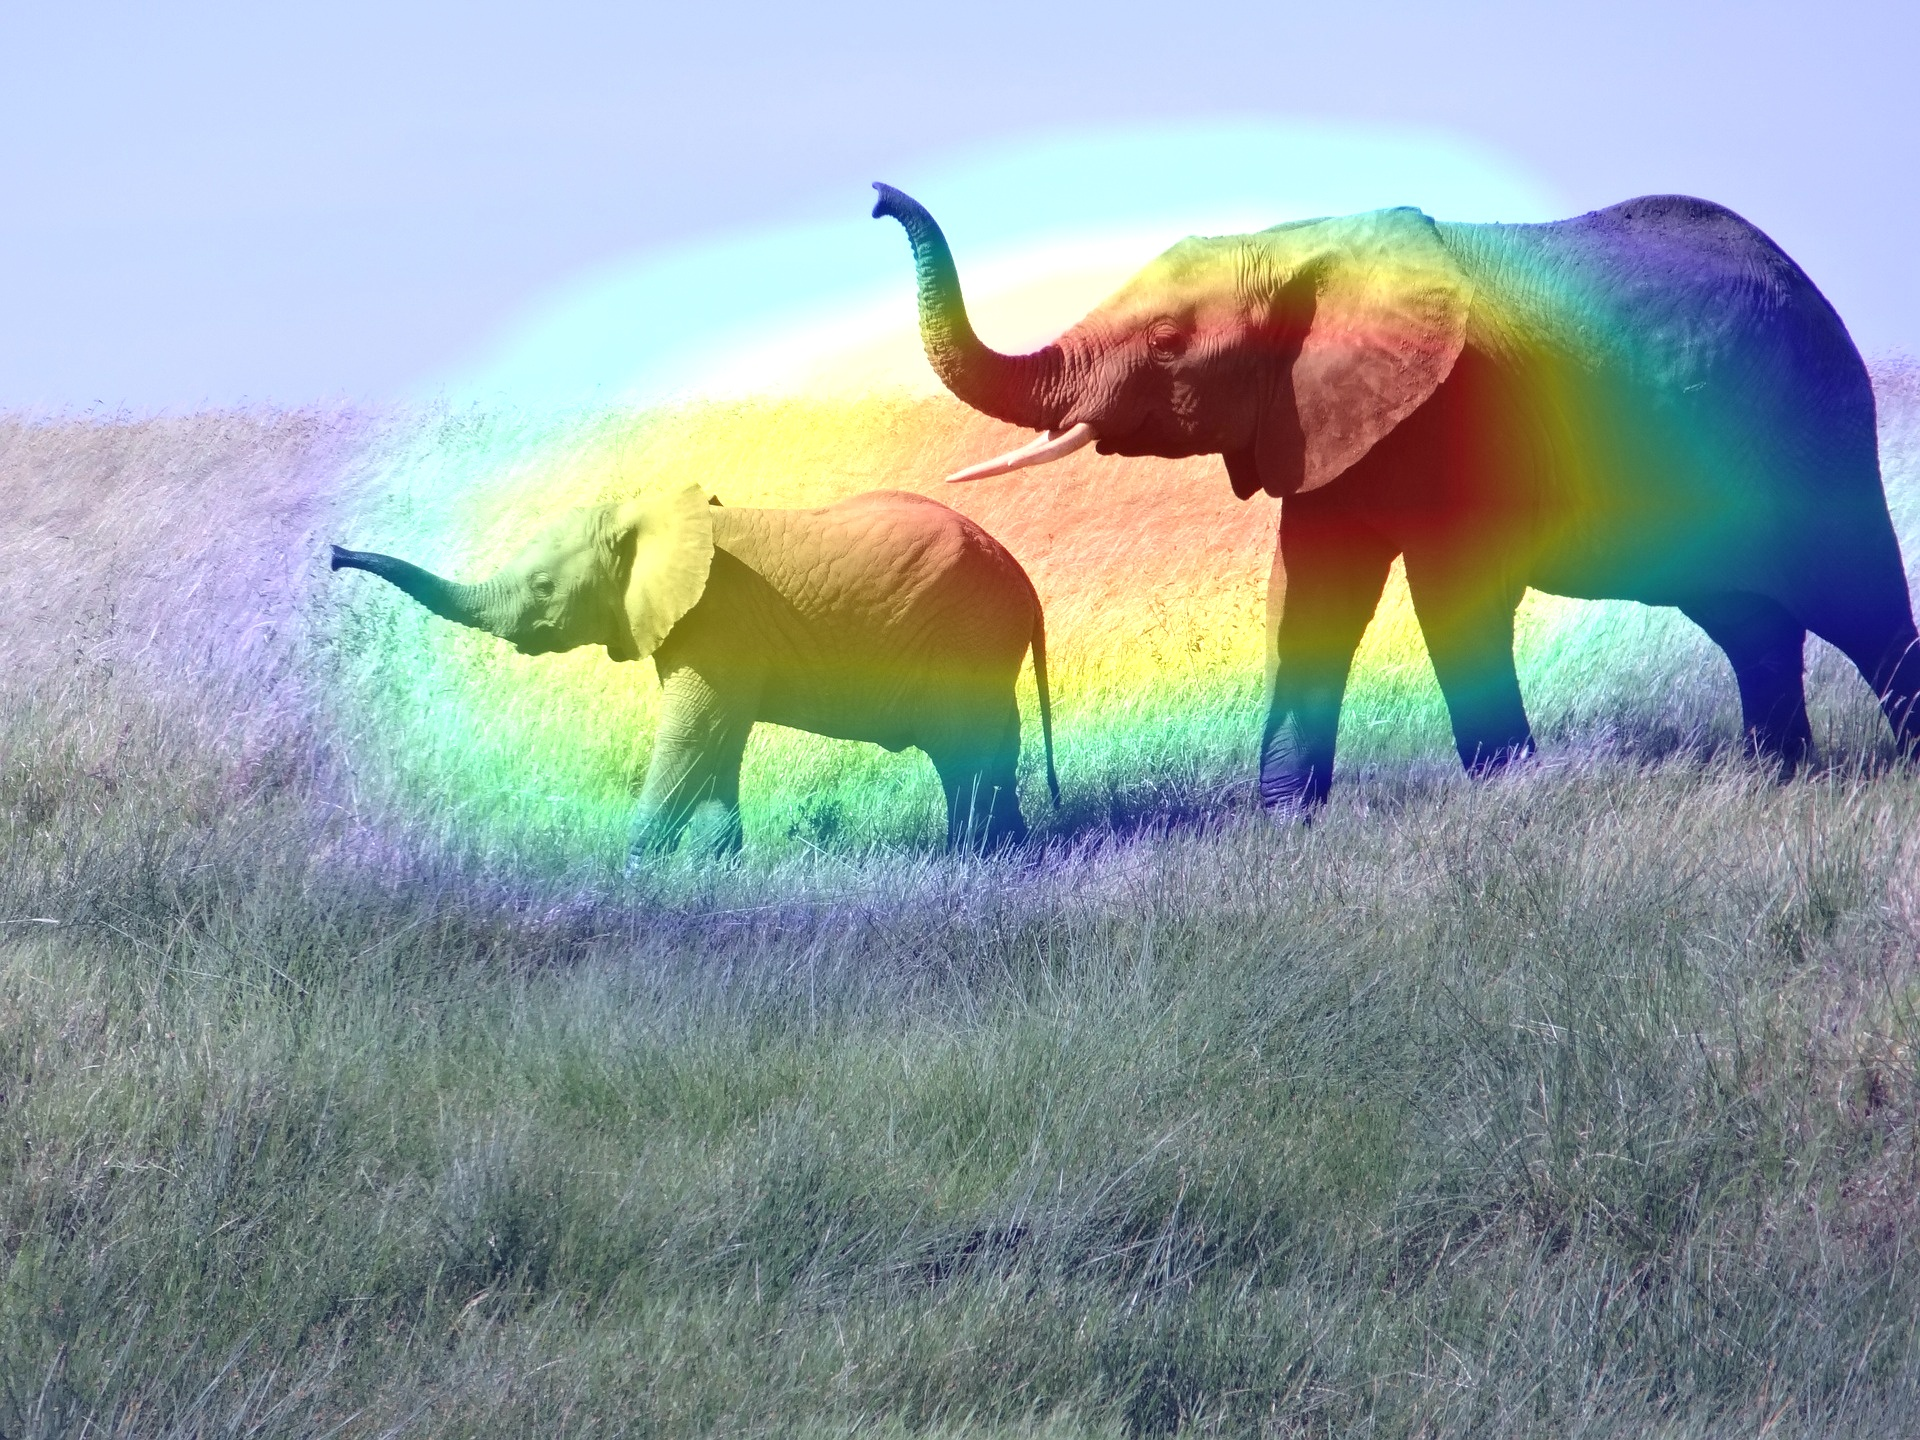

In [0]:
display(Image(save_path))